In [8]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
import shutil
from IPython.display import FileLink
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
def load_and_resize_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            with Image.open(img_path) as img:
                img = img.convert('L')
                img = img.resize((108, 108))
                img_array = np.array(img)
                images.append(img_array)
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
    return images


def build_generator(latent_dim):
    model = models.Sequential()

    model.add(layers.Dense(256 * 27 * 27, input_dim=latent_dim))
    model.add(layers.Reshape((27, 27, 256)))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(1, kernel_size=3, strides=1, padding='same', activation='tanh'))

    return model


def build_discriminator(img_shape):
    model = models.Sequential()

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model


def train_gan(epochs, batch_size):
    batch_count = x_train.shape[0] // batch_size

    for epoch in range(epochs):
        d_loss = 0
        g_loss = 0

        for _ in range(batch_count):
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            generated_images = generator.predict(noise)

            idx = np.random.randint(0, x_train.shape[0], batch_size)
            real_images = x_train[idx]

            labels_real = np.ones((batch_size, 1))
            labels_fake = np.zeros((batch_size, 1))

            d_loss_real = discriminator.train_on_batch(real_images, labels_real)
            d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)
            d_loss += 0.5 * (np.mean(d_loss_real) + np.mean(d_loss_fake))

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            labels_gan = np.ones((batch_size, 1))
            g_loss += gan.train_on_batch(noise, labels_gan)

        if batch_count != 0:
            d_loss /= batch_count
            g_loss /= batch_count
        else:
            print("Warning: batch_count is zero. Skipping division by zero.")

        print(f"Epoch {epoch}/{epochs} [D loss: {d_loss} | G loss: {g_loss}]")



def generate_images(generator, latent_dim, num_images=10):

    noise = np.random.normal(0, 1, (num_images, latent_dim))
    generated_images = generator.predict(noise)

    return generated_images



In [10]:
folder_path_negative = '/content/drive/MyDrive/BrainTumorDataSet/Healthy'
folder_path_positive = '/content/drive/MyDrive/BrainTumorDataSet/BrainTumor'

positive_images = load_and_resize_images(folder_path_positive)
negative_images = load_and_resize_images(folder_path_negative)

In [11]:
x_train = np.array(positive_images + negative_images)
x_train = x_train.astype('float32') / 255.0

print("Shape of the array:", x_train.shape)

Shape of the array: (4016, 108, 108)


In [17]:
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 200
batch_size = 64

In [18]:
generator = build_generator(latent_dim)
discriminator = build_discriminator((108, 108, 1))

discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr, beta_1=beta1, beta_2=beta2), metrics=['accuracy'])

discriminator.trainable = False
gan = models.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr, beta_1=beta1, beta_2=beta2))

In [19]:
train_gan(epochs=num_epochs, batch_size=batch_size)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 17ms/step
Epoch 120/200 [D loss: 0.5000000068819658 | G loss: 4.287591034499787e-06]
2/2 [==============================] - 0s 16ms/step
Epoch 121/200 [D loss: 0.5000000072065348 | G loss: 4.251106782894274e-06]
2/2 [==============================] - 0s 16ms/step
Epoch 122/200 [D loss: 0.5000000078755956 | G loss: 4.755891825792083e-06]
2/2 [==============================] - 0s 16ms/step
Epoch 123/200 [D loss: 0.5000000065726913 | G loss: 4.575304307118424e-06]
2/2 [==============================] - 0s 16ms/step
Epoch 124/200 [D loss: 0.5000000043286144 | G loss: 4.28584554180317e-06]
2/2 [==============================] - 0s 16ms/step
Epoch 125/200 [D loss: 0.5000000057660668 | G loss: 4.073886936068096e-06]
2/2 [==============================] - 0s 16ms/step
Epoch 126/200 [D loss: 0.5000000077089226 | G loss: 4.034348201516437e-06]
2/2 [==============================] - 0s 16ms/step
Epoch 127

1/1 [==============================] - 0s 130ms/step


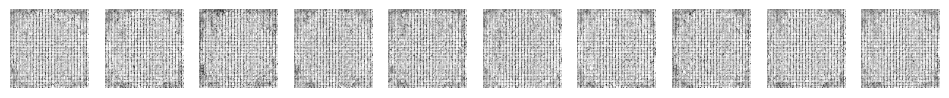

In [20]:
num_generated_images = 10
generated_images = generate_images(generator, latent_dim, num_generated_images)

fig, axes = plt.subplots(1, num_generated_images, figsize=(12, 2))

for i in range(num_generated_images):
    axes[i].imshow(generated_images[i].reshape(108, 108), cmap='gray')
    axes[i].axis('off')

plt.show()

In [21]:
output_folder = '/content/generated_images'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for i in range(num_generated_images):
    img_array = (generated_images[i] * 255).astype(np.uint8)
    img = Image.fromarray(img_array.reshape(108, 108))
    img_path = os.path.join(output_folder, f'generated_image_{i + 1}.png')
    img.save(img_path)


shutil.make_archive('/content/generated_images', 'zip', output_folder)


FileLink(r'/content/generated_images.zip')

/content/generated_images.zip